In [55]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For creating visualizations
import seaborn as sns  # For advanced data visualizations 
import re  # For regular expressions used in text cleaning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Input, Dense, Dropout, concatenate, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder
from sklearn.preprocessing import StandardScaler  # Import StandardScaler
from sklearn.model_selection import train_test_split  # Import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer  # Import TfidfVectorizer

In [45]:
# 1. Load the Dataset
data_path = r"C:\Users\hewi7\Dropbox\PC\Downloads\Data Science Project\fake_job_postings.csv\fake_job_postings.csv"
df = pd.read_csv(data_path)

In [46]:
#2. Data Understanding
print("Dataset Info:\n")
df.info()  #Display information about dataset columns and data types

print("\nSummary statistics:\n")
print(df.describe())  # Show summary statistics for numerical columns

print("\nClass Distribution:\n")
print(df['fraudulent'].value_counts())  # Display distribution of target lables

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  o

In [47]:
# 3. Data Cleaning and Preprocessing
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'<[^a-zA-Z]', '', text)  # Remove non-alphabet characters
    text = text.lower()  # Convert text to lowercase
    return text  # Return cleaned text

In [48]:
df['cleaned_description'] = df['description'].fillna('').apply(clean_text)  # Apply cleaning function to text data

In [49]:
# Handle missing values and categorical features
df.fillna({'location': 'Unknown', 'employment_type': 'Unknown', 'required_experience': 'Unkown'}, inplace = True)  # Fill missing values
categorical_cols = ['location', 'employment_type', 'required_experience']  # List of categorical columns
encoder = LabelEncoder()  # Initialize lable encoder
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])  # Encode categorical variables

In [50]:
# Scale numerical features
scaler = StandardScaler()  # Initialize scaler for numerical features
df[['location', 'employment_type', 'required_experience']] = scaler.fit_transform(df[['location', 'employment_type', 'required_experience']])  # Scale features

In [51]:
# 4. Feature Engineering
vectorizer = TfidfVectorizer(max_features=1000) #  Initialize TF-IDF vectorizer with a maximum of 5000 features
text_features = vectorizer.fit_transform(df['cleaned_description']).toarray()  # Transform text data into numerical features

In [52]:
# Combine features
X = np.hstack((text_features, df[['location', 'employment_type', 'required_experience']].values))  # Combine text and meta features
y = df['fraudulent']  # Target variable

In [56]:
# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)  # Split data into training and testing sets

In [57]:
# Deep Neural Network (DNN) Model 
# 6. One-Hot Encode the Target Variables
y = df['fraudulent']  # Assign the target variable to y

from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(y, num_classes=2)  # Convert target variable to one-hot encoding

In [58]:
# 7. Define the Text Input Model
text_input = Input(shape = (text_features.shape[1],), name ='text_input')  # Test input 
text_dense = Dense(128, activation = 'relu')(text_input)  # Dense layer for tabular features
text_dropout = Dropout(0.5)(text_dense)  # Dropout for regularization

In [59]:
# 8. Define the Tabular Model
tabular_input = Input(shape=(df[['location', 'employment_type', 'required_experience']].shape[1],), name = 'tabular_input')
tabular_dense = Dense(32, activation = 'relu')(tabular_input)  # Dense layer for tabular features
tabular_dropout = Dropout(0.5)(text_dense)  # Dropout for regularization

In [60]:
# 9. Combine Text and Tabular Models
combined = concatenate([text_dropout, tabular_dropout])  # Concatenate outputs of both inputs
combined_dense = Dense(64, activation = 'relu')(combined)  # Additional dense layer
output = Dense(2, activation = 'softmax', name = 'output')(combined_dense)  # Output layer with softmax for classification

In [61]:
# Compile the Model
model = Model(inputs = [text_input, tabular_input], outputs = output)  # Define the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the model

In [62]:
# 10. Train the Model
history = model.fit(
    [text_features, df[['location', 'employment_type', 'required_experience']].values],  # Input
    y_one_hot,  # Target
    validation_split = 0.2,  # 20% validation data
    epochs = 20,  # Btch size
    verbose = 1  # Display training progress
)

Epoch 1/20
447/447 [==============================] - 2s 4ms/step - loss: 0.1376 - accuracy: 0.9615 - val_loss: 0.2389 - val_accuracy: 0.9091
Epoch 2/20
447/447 [==============================] - 1s 3ms/step - loss: 0.0814 - accuracy: 0.9747 - val_loss: 0.1989 - val_accuracy: 0.9379
Epoch 3/20
447/447 [==============================] - 1s 3ms/step - loss: 0.0580 - accuracy: 0.9830 - val_loss: 0.2132 - val_accuracy: 0.9390
Epoch 4/20
447/447 [==============================] - 1s 3ms/step - loss: 0.0424 - accuracy: 0.9881 - val_loss: 0.2449 - val_accuracy: 0.9402
Epoch 5/20
447/447 [==============================] - 1s 3ms/step - loss: 0.0262 - accuracy: 0.9935 - val_loss: 0.2593 - val_accuracy: 0.9402
Epoch 6/20
447/447 [==============================] - 2s 3ms/step - loss: 0.0178 - accuracy: 0.9952 - val_loss: 0.3046 - val_accuracy: 0.9421
Epoch 7/20
447/447 [==============================] - 1s 3ms/step - loss: 0.0109 - accuracy: 0.9969 - val_loss: 0.3656 - val_accuracy: 0.9418
Epoch 

In [63]:
# 11. Evaluate the Model
loss, accuracy = model.evaluate(
      [X_test[:, :text_features.shape[1]], X_test[:, text_features.shape[1]:]],  # Test inputs
      to_categorical(y_test, num_classes = 2)  # Test target
)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

112/112 [==============================] - 0s 2ms/step - loss: 0.1128 - accuracy: 0.9913
Test Loss: 0.11278873682022095
Test Accuracy: 0.9913311004638672


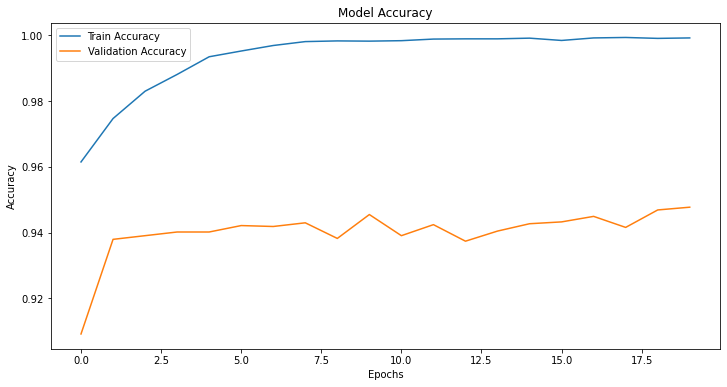

In [64]:
# 12. Visualize Training History
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

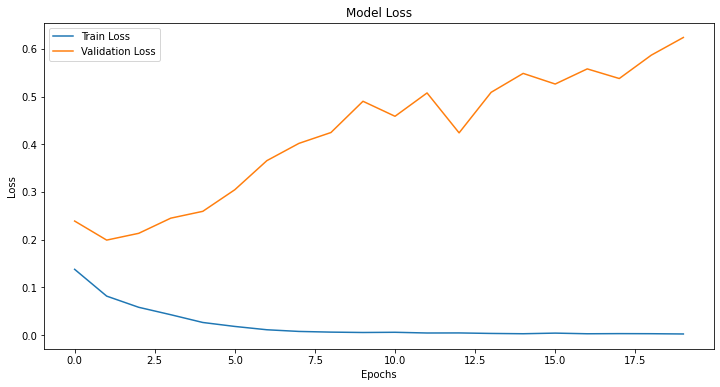

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [66]:
## LSTM Model
# 1. Test Tokenization and Padding
max_vocab_size = 10000  # Maximum length of unique tokens
max_sequence_length = 200  # Maximum length of a text sequence

tokenizer = Tokenizer(num_words = max_vocab_size, oov_token = '<00v>')  # Initialize tokenizer
tokenizer.fit_on_texts(df['cleaned_description'])  # Fit tokenizer on cleaned text data

In [67]:
# Conver text to sequences and pad them
sequences = tokenizer.texts_to_sequences(df['cleaned_description'])
padded_sequences = pad_sequences(sequences, maxlen = max_sequence_length, padding = 'post', truncating = 'post')

In [68]:
# 2. one-Hot Encode the Target variable
y_one_hot = to_categorical(y, num_classes = 2)  # Covert target variable to one-hot encodeing

In [69]:
# 3. Train-Test Split
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    padded_sequences, y_one_hot, test_size = 0.2, random_state = 42, stratify = y
)

In [70]:
# 4. Define the LSTM Model
embedding_dim = 128  # Dimensionality of the embedding layer

model = Sequential([
    Embedding(input_dim = max_vocab_size, output_dim = embedding_dim, input_length = max_sequence_length),  # Embedding layer
    Bidirectional(LSTM(128, return_sequences = False)),  # Bi-directioanl LSTM
    Dropout(0.5),  # Dropout for regularization
    Dense(64, activation = 'relu'),  # Fully connected layer
    Dropout(0.5),  # Dropout for regularization
    Dense(2, activation = 'softmax')  # Output layer for classification
])

In [71]:
# 5. Compile the Model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])  # Combile the model

In [72]:
# 6. Train the Model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_split = 0.2,  # 20% validation data
    epochs = 10,  # Number of epochs
    batch_size = 32,  # Batch size
    verbose = 1,  # Display training progress
)

Epoch 1/10
358/358 [==============================] - 89s 236ms/step - loss: 0.1522 - accuracy: 0.9612 - val_loss: 0.1020 - val_accuracy: 0.9727
Epoch 2/10
358/358 [==============================] - 102s 285ms/step - loss: 0.0599 - accuracy: 0.9811 - val_loss: 0.1012 - val_accuracy: 0.9734
Epoch 3/10
358/358 [==============================] - 106s 297ms/step - loss: 0.0298 - accuracy: 0.9910 - val_loss: 0.1241 - val_accuracy: 0.9657
Epoch 4/10
358/358 [==============================] - 97s 272ms/step - loss: 0.0155 - accuracy: 0.9943 - val_loss: 0.1415 - val_accuracy: 0.9745
Epoch 5/10
358/358 [==============================] - 103s 287ms/step - loss: 0.0095 - accuracy: 0.9966 - val_loss: 0.1958 - val_accuracy: 0.9752
Epoch 6/10
358/358 [==============================] - 106s 296ms/step - loss: 0.0074 - accuracy: 0.9970 - val_loss: 0.2077 - val_accuracy: 0.9766
Epoch 7/10
358/358 [==============================] - 94s 262ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.1888 - va

In [ ]:
# 7. Evaluate the Model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)  # Evaluate on test data
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

 74/112 [==================>...........] - ETA: 2s - loss: 0.2262 - accuracy: 0.9776

In [ ]:
# 8. Visualize Training History
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()